# Science Demonstration Case: Polar Science
# Automatic ice damage detection from Sentinel-1 radar imagery
## Step 1: Prepare damage model datacube.
### For more info about this science case, please check the documentation [at this link](https://earthsystemdatalab.net/science_cases/polar_science/).

In this notebook the input damage models are manipulated in order to save them as data cubes into the S3 bucket.

In particular, for a given ice shelf there are three damage models available. The three models differ in the assumption on the ice temperature vertical profile:
- `surface_temp`: no vertical gradient, with temperature equal to the observed temperature at the visible surface;
- `uniform_temp`: homogeneous and constant temperature (-16°);
- `depth_temp`: constant vertical gradient assuming -16° at the surface and 0° at the bottom of the ice shelf.

These models are originally stored in `netCDF` files with a resolution of 500 m. The `netCDF` files are converted to `xarray`, with the addition of useful attributes such as:
- `units`: the meaning of the scalar values describing the damage levels, from 0 to 2;
- `description`: a verbose description of the dataset, specifying the assumption on the ice temperature vertical profile.
The three models are then joined with two binary masks, one indicating where the grounded ice (i.e., the ice sheet) is and the other one indicating where the ocean is.
The ice shelf is the area that is neither grounded ice nor ocean. Finally, the five xarrays merged into a unique xarray and saved to the S3 storage.

NB: note that the native resolution of the two binary masks is 100 m. Hence, an intermediate step is necessary to coarsen them and match the 500 m resolution of the damage models.

**This notebook runs with the python environment `polar-science-use-case`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**

In [1]:
# import the necessary packages

import os
import zipfile
from datetime import datetime
from pathlib import Path

import gdown
import netCDF4
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from xcube.core.store import new_data_store

Define the parameters needed to access the S3 storage. They are saved as environment variables.

In [ ]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

team_store = new_data_store(
    data_store_id="s3",
    root=S3_USER_STORAGE_BUCKET,
    storage_options=dict(
        anon=False, key=S3_USER_STORAGE_KEY,
        secret=S3_USER_STORAGE_SECRET
    )
)

This is the list of the available ice shelves and ice temperature vertical profile assumptions.<br>
This science case is shown for the Amery Ice Shelf.



In [6]:
ICESHELF_LIST = ["amery", "amundsen", "getz"]
TEMPERATURE_ASSUMPTION_LIST = ["surface_temp", "depth_temp", "uniform_temp"]

iceshelf_name = "amery"

Define a directory where the input data will be saved.

In [10]:
INPUT_DATA_DIRECTORY = Path.cwd() / "input_data"
INPUT_DATA_DIRECTORY.mkdir(exist_ok=True)

Get the input data for Amery Ice Shelf.<br>
Note that the data is shared via Google Drive, and the ID of the compressed file on the drive is stored as an environment variable.

In [ ]:
zip_file_path = INPUT_DATA_DIRECTORY / f"{iceshelf_name}.zip"
iceshelf_directory = INPUT_DATA_DIRECTORY / iceshelf_name

# download the data from Google Drive
gdown.download(id=os.environ["AMERY_GDRIVE_ID"], output=zip_file_path.as_posix())
# unzip the compressed file
with zipfile.ZipFile(zip_file_path, "r") as zip_content:
    zip_content.extractall(iceshelf_directory)
# remove the compressed file
zip_file_path.unlink()

Downloading...
From (original): https://drive.google.com/uc?id=1ddfujnuA_c5rqifYVfK-FqqFfOSfAOio
From (redirected): https://drive.google.com/uc?id=1ddfujnuA_c5rqifYVfK-FqqFfOSfAOio&confirm=t&uuid=308cbe23-8819-4c67-a095-333d44d8455e
To: /home/incatasciatoandrea/deepesdl-doc/notebooks/science-cases/polar-science/input_data/amery.zip
100%|██████████| 139M/139M [00:01<00:00, 85.8MB/s] 


Define a function to read the ice damage datasets contained in the netCDF files and use it for all three ice temperature assumptions.

In [13]:
def get_damage_class_from_netcdf_file(damage_class_file_path: Path, xarray_description: str) -> xr.DataArray:
    """
    Create a xarray containing the damage class dataset, reading it from an input netCDF file.

    Parameters
    ----------
    damage_class_file_path : Path
        The path to the file containing the damage class dataset.
    xarray_description : str
        The description of the dataset, that will be added to the xarray as "description" attribute.

    Returns
    -------
    xr.DataArray
        The xarray containing the damage class dataset.
    """
    with netCDF4.Dataset(damage_class_file_path, "r") as damage_class_file:
        
        # spatial coordinates
        x_coord = damage_class_file["X_coord_(m)"][:, 0].data
        y_coord = damage_class_file["Y_coord_(m)"][0][::-1].data

        # damage class: originally it is np.nan outside the ice shelf, 0 for damaged ice, 1 for intact ice, 2 for strong ice
        damage_class = damage_class_file["damage_class"][:].data
        # convert it to: 0 outside the ice shelf, 1 for damaged ice and 2 for intact or strong ice
        damage_class += 1
        damage_class[damage_class > 2] = 2
        damage_class = np.nan_to_num(damage_class, nan=0)
        # transpose due to the order of the axis
        damage_class = damage_class.astype(np.int8).T[::-1]
    
        # save the dataset as xarray.DataArray
        damage_class_xr = xr.DataArray(
            np.expand_dims(damage_class, axis=0),
            dims=("time", "y", "x"),
            coords={
                "time": [datetime(2015, 7, 1)],
                "y": y_coord,
                "x": x_coord},
            attrs=dict(
                description=xarray_description,
                units="Scalar: 0=outside ice shelf, 1=damaged ice, 2=intact or strong ice."
            ))
        return damage_class_xr

In [14]:
temperature_assumption_label = "surface_temp"
damage_class_file_path = iceshelf_directory / f"{iceshelf_name}_damage_class_{temperature_assumption_label}.nc"
description = "Damage map derived assuming that the observed surface temperature is representantive also of the deeper ice."
damage_class_surface_temp_xr = get_damage_class_from_netcdf_file(damage_class_file_path, description)

temperature_assumption_label = "depth_temp"
damage_class_file_path = iceshelf_directory / f"{iceshelf_name}_damage_class_{temperature_assumption_label}.nc"
description = "Damage map derived assuming a constant vertical temperature gradient between the surface (-16°C) and the deepest layer of the ice shelf (0°C)."
damage_class_depth_temp_xr = get_damage_class_from_netcdf_file(damage_class_file_path, description)

temperature_assumption_label = "uniform_temp"
damage_class_file_path = iceshelf_directory / f"{iceshelf_name}_damage_class_{temperature_assumption_label}.nc"
description = "Damage map derived assuming a uniform temperature everywhere (-16°C)."
damage_class_uniform_temp_xr = get_damage_class_from_netcdf_file(damage_class_file_path, description)

The binary masks for the grounded ice and the ocean are at 100 m resolution.<br>
In order to match the extent of the 500 m damage models the extent of the binary masks needs to be increased by two pixels on each side.<br>
First define a function that does so and then another function to read the binary masks and change their resolution to match the one of the damage datasets.

In [15]:
def add_buffer_for_coarsing(
        mask: np.ndarray, x_coord: np.ndarray, y_coord: np.ndarray,
        buffer_in_pixels: int, resolution_m: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Add a buffer around the mask and extent the x and y axis arrays to reflect the new extent of the mask.

    Parameters
    ----------
    mask : np.ndarray
        The 2D array representing a mask.
    x_coord : np.ndarray
        The 1D array representing the coordinates along the X axis.
    y_coord : np.ndarray
        The 1D array representing the coordinates along the Y axis.
    buffer_in_pixels : int
        The number of pixels to add along each axis.
    resolution_m : int
        The resolution of the mask, in m, given that everything is in projected coordinates.

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray]
        The mask, x_coord and y_coord arrays with a buffer added in each direction.
    """
    # add the pixels along the X direction
    mask = np.vstack((
        mask[:buffer_in_pixels],
        mask,
        mask[-buffer_in_pixels:]))
    # add the pixels along the Y direction
    mask = np.hstack((
        mask[:, :buffer_in_pixels],
        mask,
        mask[:, -buffer_in_pixels:]))

    # extend the X coordinates
    x_coord = np.concatenate([
        [x_coord[0] - resolution_m * 2, x_coord[0] - resolution_m],
        x_coord,
        [x_coord[-1] + resolution_m, x_coord[-1] + resolution_m * 2]])

    # extend the Y coordinates
    y_coord = np.concatenate([
        [y_coord[0] - resolution_m * 2, y_coord[0] - resolution_m],
        y_coord,
        [y_coord[-1] + resolution_m, y_coord[-1] + resolution_m * 2]])

    return mask, x_coord, y_coord


def get_binary_mask_from_npy_file(
        mask_file_path: Path, coord_mesh_x_file_path: Path, coord_mesh_y_file_path: Path,
        xarray_description: str, xarray_units: str) -> xr.DataArray:
    """
    Create a xarray containing a binary mask, reading it from an input npy file.

    Parameters
    ----------
    mask_file_path : Path
        The path to the file containing the binary mask.
    coord_mesh_x_file_path : Path
        The path to the file containing the X axis mesh.
    coord_mesh_y_file_path : Path
        The path to the file containing the Y axis mesh.
    xarray_description : str
        The description of the dataset, that will be added to the xarray as "description" attribute.
    xarray_units : str
        The string explaining the value of 0 and 1 in the binary mask. It will be added to the xarray as "units" attribute.

    Returns
    -------
    xr.DataArray
        The xarray containing the binary mask.
    """
    # get the binary masks
    binary_mask = np.load(mask_file_path)

    # get also the X and Y axis coordinate meshes
    # NB: the unit in these files is [km]
    coord_mesh_x = np.load(coord_mesh_x_file_path)
    coord_mesh_y = np.load(coord_mesh_y_file_path)

    binary_mask_with_buffer, x_with_buffer, y_with_buffer = add_buffer_for_coarsing(
        binary_mask.astype(np.int8),
        coord_mesh_x[0] * 1e3,
        coord_mesh_y[:, 0] * 1e3,
        2, 100)

    binary_mask_with_buffer_xr = xr.DataArray(
        np.expand_dims(binary_mask_with_buffer, axis=0),
        dims=("time", "y", "x"),
        coords={
            "time": [datetime(2015, 7, 1)],
            "y": y_with_buffer,
            "x": x_with_buffer},
        attrs=dict(
            description=xarray_description,
            units=xarray_units))
    binary_mask_xr = binary_mask_with_buffer_xr.coarsen(x=5).median().coarsen(y=5).median().astype(np.int8)
    return binary_mask_xr

Use the functions previously defined to read the grounded ice and the ocean masks.

In [16]:
coord_mesh_x_file_path = iceshelf_directory / f"{iceshelf_name}_xcoord_mesh.npy"
coord_mesh_y_file_path =iceshelf_directory / f"{iceshelf_name}_ycoord_mesh.npy"

grounded_ice_mask_file_path = iceshelf_directory / f"{iceshelf_name}_grounded_ice_mask.npy"
xarray_description = "Ice Sheet mask from BedMachine."
xarray_units = "Scalar: 0=other, 1=grounded ice."
grounded_ice_mask_xr = get_binary_mask_from_npy_file(
    grounded_ice_mask_file_path, coord_mesh_x_file_path, coord_mesh_y_file_path,
    xarray_description, xarray_units)

ocean_mask_file_path = iceshelf_directory / f"{iceshelf_name}_ocean_mask.npy"
xarray_description = "Ocean mask from BedMachine."
xarray_units = "Scalar: 0=other, 1=ocean."
ocean_mask_xr = get_binary_mask_from_npy_file(
    ocean_mask_file_path, coord_mesh_x_file_path, coord_mesh_y_file_path,
    xarray_description, xarray_units)

Create the datacube containing the binary masks and the damage class map for the three cases and save it to the S3 storage.

In [ ]:
# merge the xarrays

amery_datacube_res_500m = xr.merge([
    ocean_mask_xr.rename("ocean_mask"),
    grounded_ice_mask_xr.rename("grounded_ice_mask"),
    damage_class_surface_temp_xr.rename("damage_class_surface_temp"),
    damage_class_depth_temp_xr.rename("damage_class_depth_temp"),
    damage_class_uniform_temp_xr.rename("damage_class_uniform_temp")],
    join="exact")


# the attributes are initially copied from the first xarray:
# update the description and delete the units
# NB: the original attributes still exist and are correctly assigned to the corresponding data variable

amery_datacube_res_500m = amery_datacube_res_500m.assign_attrs(
    description="Datacube relative to the Amery Ice Shelf, \
containing the three damage models and the ocean and grounded ice masks.")
del amery_datacube_res_500m.attrs["units"]


# set the CRS and the chunking, for fast memory access

amery_datacube_res_500m = amery_datacube_res_500m.rio.write_crs("epsg:3031", grid_mapping_name="crs")
amery_datacube_res_500m = amery_datacube_res_500m.chunk(dict(time=1, x=128, y=128))


# save the datacube to the S3 storage

storage_path = f"datacubes/{iceshelf_name}/damage_models_res_500m.zarr"
team_store.write_data(
    amery_datacube_res_500m, storage_path, replace=False)

'datacubes/amery/damage_models_res_500m.zarr'

### usage example: retrieve the data from the S3 storage and plot a subset

In [42]:
datacube_storage_path = f"datacubes/{iceshelf_name}/damage_models_res_500m.zarr"

First get the description of the datacube.

In [43]:
data_cube_description = team_store.describe_data(datacube_storage_path)

# for example print the bounding box and the coordinates
print(data_cube_description.bbox)
for coord_variable in data_cube_description.coords.values():
    print(coord_variable.to_dict())

(1566250.0, 533250.0, 2266750.0, 933750.0)
{'name': 'time', 'dtype': 'datetime64[ns]', 'dims': ['time']}
{'name': 'x', 'dtype': 'float64', 'dims': ['x']}
{'name': 'y', 'dtype': 'float64', 'dims': ['y']}


Access the datacube, load only a subset of it and plot it.

In [44]:
datacube = team_store.open_data(datacube_storage_path)


# define the extent of the area of interest and load only the data within that area

x_min = 2205500
x_max = 2230500
y_min = 690000
y_max = 710000

subset_datacube = datacube.sel(
    time=datetime(2015, 7, 1),
    x=slice(x_min, x_max),
    y=slice(y_min, y_max))

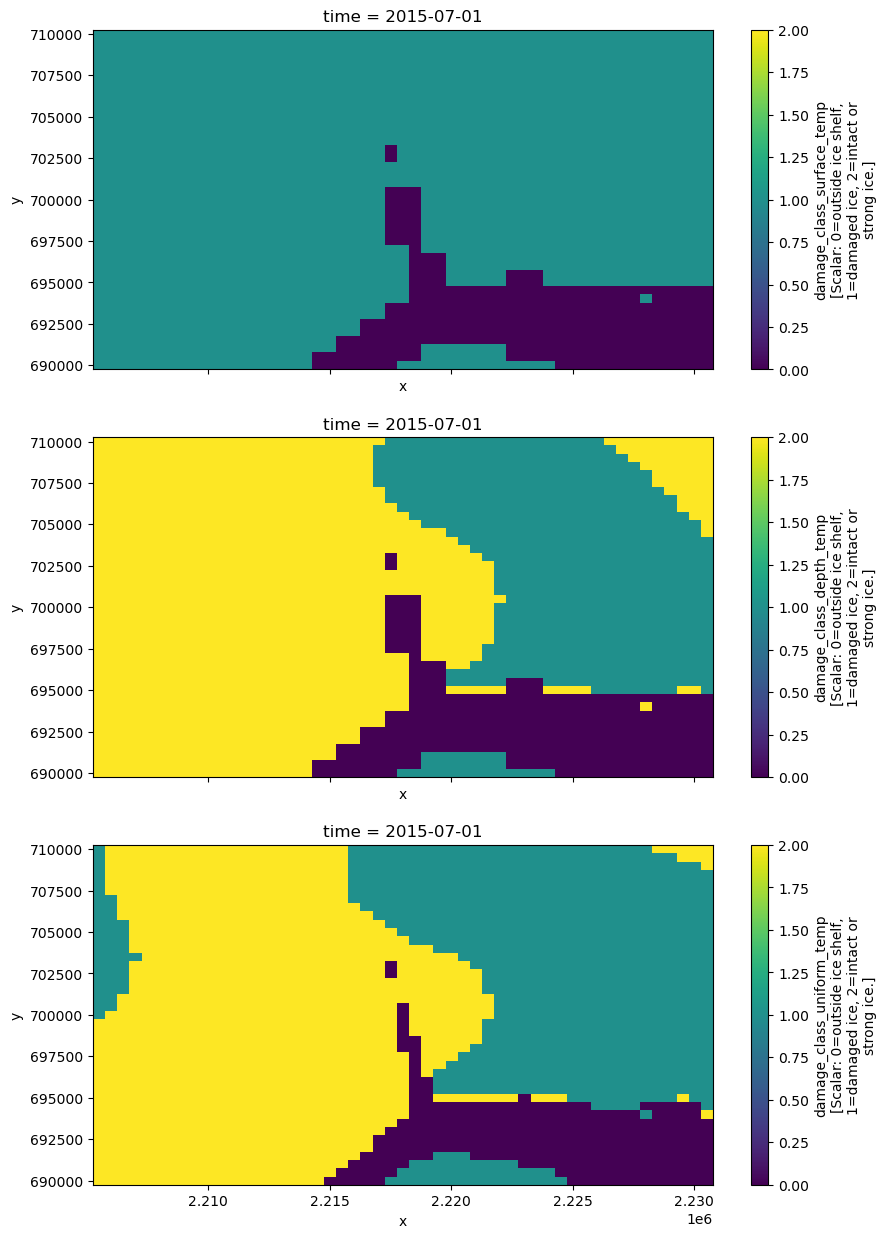

In [45]:
# plot the three models within the area of interest

fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(10, 15))
subset_datacube.damage_class_surface_temp.plot.imshow(ax=axes[0], vmin=0, vmax=2)
subset_datacube.damage_class_depth_temp.plot.imshow(ax=axes[1], vmin=0, vmax=2)
subset_datacube.damage_class_uniform_temp.plot.imshow(ax=axes[2], vmin=0, vmax=2)